Modelo de clasificación de imágenes con transferencia de aprendizaje
====================================================================

En este notebook revisaremos como es el diseño de una red neuronal basada en convoluciones para la clasificación de imagenes. En particular, utilizaremos el conocido desafío de Kaggle "Gatos vs Perros" donde la tarea consiste en crear un clasificador capaz de clasificar imagenes que continen gatos o perros. El mejor modelo de este desafío consige un categorization accuracy de 98,9%.

## Preparación del ambiente

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Intalamos las librerias necesarias

In [ ]:
!pip install tensorflow-datasets
!pip install matplotlib

Necesitaremos GPUs!

In [ ]:
import tensorflow as tf
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPUs disponibles:  1


## Sobre el problema a resolver

CIFAR-10 es un dataset que consiste en 60.000 imagenes a color de 32x32 agrupadas en 10 clases, con 6000 imagenes cada una. Hay alrededor de 50000 imagenes para entrenamiento y 10000 para testing.

Las categorias son:
 - airplane
 - automobile
 - bird
 - cat
 - deer
 - dog
 - frog
 - horse
 - ship
 - truck

In [9]:
import tensorflow_datasets as tfds
import tensorflow.keras as keras
ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True)

In [ ]:
print("Numero de clases: ", info.features["label"].num_classes)
print("Clases disponibles: ", info.features["label"].names)

Numero de clases:  10
Clases disponibles:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Veamos algunos ejemplos:

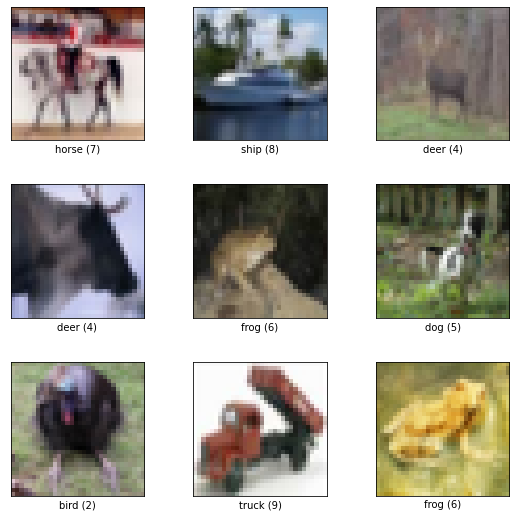

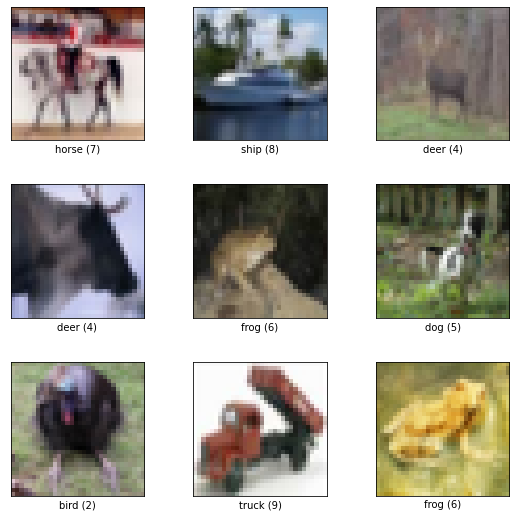

In [ ]:
tfds.show_examples(ds, info)

## Construcción de una red neuronal convolucional

### Entendiendo una estructura basada en CNN estandar

En este primer intento de solución del problema, generaremos una red basada en CNNs típica. En este caso la misma constará de:
 - 3 capas de CNN
 - 3 capas de Pooling
 - Una red de 2 capas fully-connected

In [10]:
def buildModel():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(10))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return model

Instanciamos nuestro modelo y verificamos su arquitectura

In [12]:
import tensorflow as tf

model = buildModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

Antes de comenzar el entrenamiento, configuraremos nuestro set de datos para una tarea supervisada. Esto lo hacemos especificando el parametro *as_supervised=True*

In [13]:
ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True, as_supervised=True)

In [14]:
BATCH_SIZE=64

bs = ds.cache().batch(batch_size=BATCH_SIZE)

Comenzamos el entrenamiento

In [15]:
EPOCHS = 10

In [ ]:
history = model.fit(bs, epochs=EPOCHS)

Epoch 1/10
782/782 [==============================] - 67s 85ms/step - loss: 1.9959 - accuracy: 0.3231
Epoch 2/10
429/782 [===============>..............] - ETA: 26s - loss: 1.4714 - accuracy: 0.4696

### Transfer Learning

En esta ocación utilizaremos un modelo basado en Transfer Learning el cual operará como extractor de features para nuestro modelo.

In [ ]:
EPOCHS = 10
BATCH_SIZE=64

In [ ]:
import tensorflow_datasets as tfds

ds, info = tfds.load('cifar10', split='train', shuffle_files=True, with_info=True, as_supervised=True)

In [ ]:
print(info.features["label"].num_classes)
print(info.features["label"].names)

10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
image_input = keras.layers.Input(shape=(224, 224, 3))

#### Ajustando el tamaño de nuestras imagenes

ResNet es un modelo que se entrenó utilizando imagenes de tamaño 224x224. Sin embargo, nuestras imagenes podrían no tener este tamaño e incluso podrían no tener el mismo tamañao. ¿Como hacemos para ajustar el tamaño? Utilizaremos una técnica similar a cuando ajustamos la longitud de las secuencias en NLP. Padding. Padding agregará ceros en en la imagen hasta completar el tamaño especificado: 

<img src="https://th.bing.com/th/id/OIP.8D8BXN3aHLCyTNTE2GssmQAAAA?pid=Api&rs=1" />

En TensorFlow, esto lo podemos realizar utilizando el metodo *padded_batch* el cual agrupa las imagenes en batches para entrenamiento y al mismo tiempo ajusta el tamaño de los tensores al necesitado:

In [ ]:
bs = ds.cache().padded_batch(batch_size=BATCH_SIZE, padded_shapes=([224, 224, 3], []))

#### Construimos nuestro modelo basado en ResNet50

Construiremos nuestro modelo basado en ResNet50. ResNet-50 es una CNN de 50 capas de profundidad que utiliza el concepto de skip-connection, de una forma similar a la que se utiliza por el sistema de visión humano. Esta implemnetación le permite a la red reutilizar las activaciones de capas anteriores y asi no solo mapear conceptos que se aprendieron en otra jerarquia de la red sino que también evitar el problema de desaparición de los gradientes.

<img src="http://www.jesusutrera.com/articles/img/resnet.png" width=1000 />

Podemos construir un modelo utilizando ResNet desde Keras utilizando el layer de tal tipo.

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

def buildModel():
    model = keras.models.Sequential()
    model.add(ResNet50(include_top=False, pooling='none', weights='imagenet', input_tensor = image_input))
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    model.layers[0].trainable = False
    model.compile(optimizer="adam",
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])
    
    return model

Instanciamos nuestro modelo en una variable

In [ ]:
model = buildModel()

Podemos ver la estructura de nuestro modelo:

In [ ]:
model.summary()

Iniciamos el entrenamiento

In [ ]:
history = model.fit(bs, epochs=EPOCHS)

Epoch 1/10
782/782 [==============================] - 357s 456ms/step - loss: 2.0674 - accuracy: 0.3921
Epoch 2/10
782/782 [==============================] - 352s 451ms/step - loss: 1.9808 - accuracy: 0.4815
Epoch 3/10
782/782 [==============================] - 352s 451ms/step - loss: 1.9509 - accuracy: 0.5135
Epoch 4/10
782/782 [==============================] - 352s 451ms/step - loss: 1.9308 - accuracy: 0.5379
Epoch 5/10
782/782 [==============================] - 352s 451ms/step - loss: 1.9175 - accuracy: 0.5518
Epoch 6/10
782/782 [==============================] - 352s 450ms/step - loss: 1.9053 - accuracy: 0.5663
Epoch 7/10
782/782 [==============================] - 352s 451ms/step - loss: 1.8972 - accuracy: 0.5746
Epoch 8/10
782/782 [==============================] - 352s 451ms/step - loss: 1.8892 - accuracy: 0.5837
Epoch 9/10
782/782 [==============================] - 352s 451ms/step - loss: 1.8838 - accuracy: 0.5896
Epoch 10/10
782/782 [==============================] - 352s 451m

#### ¿Porque les parece que este modelo no funciona bien?